## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
import h5py
from scipy.integrate import quad
from data_generation.variables import *
import pandas as pd

import pickle

import warnings

warnings.filterwarnings('ignore')

/Users/nolansmyth/opt/anaconda3/envs/kinetic_recoupling/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
h5pydir = 'h5py_dat/'
plt.style.use("/Users/nolansmyth/Dropbox/kinetic_recoupling/figures/style.mplstyle")

## Resonance vs delta Rate comparison

In [3]:
import csv

In [4]:
T, rate = [], []
with open('interps/resonant_rate.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        T.append(float(row[0]))
        rate.append(float(row[1]))

In [5]:
rate_interp = UnivariateSpline(T, rate, s=0, k=1)

In [6]:
def scientific_format(x):
    s = '%.1e' % x
    mantissa, exponent = s.split('e')
    return r'${} \times 10^{{{}}}$'.format(mantissa, int(exponent))    

def my_dmu_idm_dr(z, A_rec, a_idm_dr = 1, Omega0_idm_dr = 0.12038, T_rec = 6.0e5, xi_idr = 0.3, sigma_fac = 0.001):

    sigma = sigma_fac*T_rec
    base_rate = a_idm_dr * ((1+z)/(1e7))**4 * Omega0_idm_dr 
    T_idr = (xi_idr * 2.73) * (1+z)
    delta = T_idr - T_rec
    delta = delta/sigma
    gauss = np.exp(-pow(delta,2)/2)/np.sqrt(2*np.pi)

    return base_rate * (1 + A_rec / sigma * gauss)


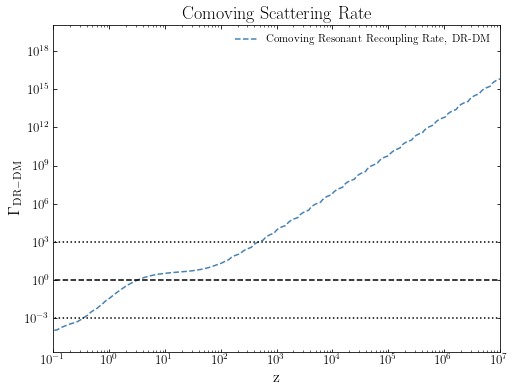

In [30]:
A_recs = [1e16, 1e18]

z_data = np.geomspace(1e-3,1e8,int(1e5))

# plt.plot(z_data, my_dmu_idm_dr(z_data, A_recs[-2], T_rec=6e5, sigma_fac=0.01), '.', label='A_rec = {}'.format(scientific_format(A_recs[-2])))
# plt.plot(z_data, my_dmu_idm_dr(z_data, A_recs[-1], T_rec=6e5, sigma_fac=0.01), '.', label='A_rec = {}'.format(scientific_format(A_recs[-1])))

plt.loglog(z_data, (rate_interp((1+z_data)*0.3*2.73)/((1+z_data)*0.3*2.73)), '--', label='Comoving Resonant Recoupling Rate, DR-DM')

plt.plot([1e-3,1e10], [1,1], 'k--')
plt.plot([1e-3,1e10], [1e-3,1e-3], 'k:')
plt.plot([1e-3,1e10], [1e3,1e3], 'k:')

plt.xlim(1e-1,1e7)
# plt.ylim(1e-3,1e3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('z', fontsize=16)
plt.ylabel('$\Gamma_{\mathrm{DR-DM}}$', fontsize=16)
plt.title('Comoving Scattering Rate')
plt.legend()
plt.show()

In [33]:
scientific_format(max(z_data))

'$1.0 \\times 10^{8}$'

In [15]:
h5pydir = 'h5py_dat/'
data_file=h5pydir+'class_model_data_no_rec.hdf5'
with h5py.File(data_file, 'r') as f:
    z_data = np.flip(np.array(f['thermodynamics']['z']))
    thermo_tau_data = np.flip(np.array(f['thermodynamics']['conf. time [Mpc]']))
    thermo_taus = UnivariateSpline(np.flip(z_data), np.flip(thermo_tau_data), **spline_pars)
    a_data = 1/(1+z_data)
    a = UnivariateSpline(thermo_tau_data, a_data, **spline_pars)
    aprime = a.derivative()

    rho_idr_data = np.array(f["background"]["(.)rho_idr"])
    rho_idm_data = np.array(f["background"]["(.)rho_idm_dr"])
    bkg_tau_data = np.array(f["background"]["conf. time [Mpc]"])
    rho_idr = UnivariateSpline(bkg_tau_data, rho_idr_data, **spline_pars)
    rho_idm = UnivariateSpline(bkg_tau_data, rho_idm_data, **spline_pars)


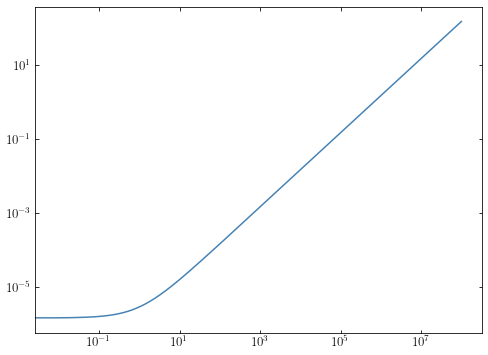

In [36]:
plt.loglog(z_data, rho_idr(thermo_taus(z_data))/rho_idm(thermo_taus(z_data)), label='rho_idr/rho_idm')

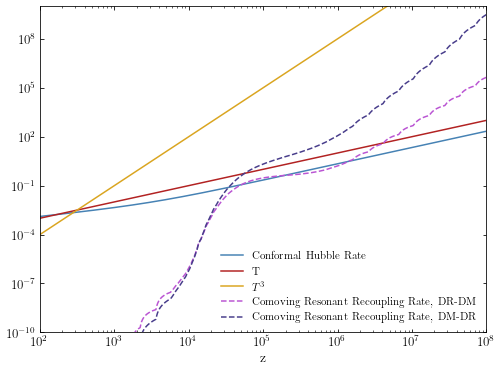

In [8]:
T_dr = (1+z_data)*0.3*2.73
T_dr_ev = T_dr * ktoev

plt.loglog(z_data, aprime(thermo_taus(z_data))/a(thermo_taus(z_data)), label='Conformal Hubble Rate')
plt.loglog(z_data, 1e-5*z_data, label='T')
plt.loglog(z_data, 1e-10*z_data**3, label='$T^3$')
plt.loglog(z_data, 1e-1*rate_interp(T_dr_ev)/T_dr_ev, '--', label='Comoving Resonant Recoupling Rate, DR-DM')
plt.loglog(z_data, 1e-1*rate_interp(T_dr_ev), '--', label='Comoving Resonant Recoupling Rate, DM-DR')

plt.xlim(1e2, 1e8)
plt.ylim(1e-10, 1e10)
plt.xlabel('z')

plt.legend()
plt.show()


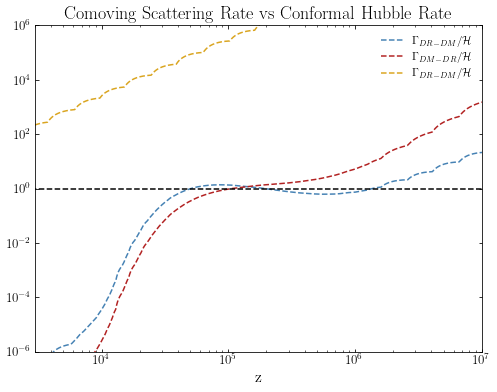

In [9]:
plt.loglog(z_data, 1e-1*(rate_interp(T_dr_ev)/(T_dr_ev))/(aprime(thermo_taus(z_data))/a(thermo_taus(z_data))), '--', label='$\Gamma_{DR-DM} / \mathcal{H}$')
plt.loglog(z_data, 1e-2*(rate_interp(T_dr_ev))/(aprime(thermo_taus(z_data))/a(thermo_taus(z_data))), '--', label='$\Gamma_{DM-DR} / \mathcal{H}$')



# plt.loglog(z_data, 3e-6*(rate_interp((1+z_data)*0.3*2.73))/(aprime(thermo_taus(z_data))/a(thermo_taus(z_data))), '--', label='Gamma DM-DR / conformal Hubble')

plt.plot([1e-3,1e10], [1,1], 'k--')
plt.xlim(3e3,1e7)
plt.ylim(1e-6,1e6)
plt.title('Comoving Scattering Rate vs Conformal Hubble Rate')
plt.xlabel('z', fontsize=16)
# plt.ylabel('$\Gamma_{\mathrm{DR-DM}}/H$', fontsize=16)
plt.legend()
plt.show()


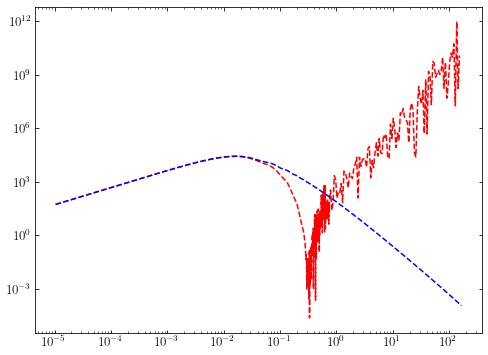

In [14]:
res_dat_path = "output/resTest01_pk.dat"

lambda_data_path = "output/lambdacdm00_pk.dat"

try:
    df_res = pd.read_csv(
        res_dat_path, header=None, names=["k", "P(k)"], skiprows=4, delimiter="\s+",
    )
    df_lambda = pd.read_csv(
        lambda_data_path, header=None, names=["k", "P(k)"], skiprows=4, delimiter="\s+",
    )
except FileNotFoundError:
    print("ERROR: No file found for that warm dm mass")


plt.loglog(
    df_res["k"],
    df_res["P(k)"],
    "r--",
    label="resonance")

plt.loglog( df_lambda["k"], df_lambda["P(k)"], "b--", label="lambdaCDM")

## Generate Data (shouldn't need to touch unless re-running CLASS)

In [3]:
from classy import Class

In [4]:
def getPk(classObj):
    kk = np.logspace(-4,np.log10(pk_max),500) # k in h/Mpc
    Pk = [] # P(k) in (Mpc/h)**3
    h = classObj.h() # get reduced Hubble for conversions to 1/Mpc
    for k in kk:
        Pk.append(classObj.pk(k*h,z_pk)*h**3) # function .pk(k,z)
    return Pk;

def getPkRatio(classObj1, classObj2):
    #Returns the ratio of the power spectrum of 1 to 2
    return[getPk(classObj1)[i]/getPk(classObj2)[i] for i in range(len(kk))]
    

def getdmu_idm_dr(classObj):
    return classObj.get_thermodynamics()['dmu_idm_dr']
    
def getzs(classObj):
    return classObj.get_thermodynamics()['z']

def getH(classObj):
    zs = np.flip(classObj.get_background()['z'])
    Hs = np.flip(classObj.get_background()['H [1/Mpc]'])
    return UnivariateSpline(zs, Hs, k=1.0, s=0.0)


def getDat(classObj):
    dmu_idm_dr = getdmu_idm_dr(classObj);
    zs = getzs(classObj)
    Hspline = getH(classObj)
    
    return dmu_idm_dr, zs, Hspline

def save_class_obj(class_obj,A_rec):
    model = class_obj
    data_file=h5pydir+'class_model_data_saturation' +'%.2e'%A_rec+'.hdf5'
    with h5py.File(data_file, 'w') as f:    
        # Scalar group
        data = model.get_perturbations()['scalar']
        sub_group = f.create_group('scalar')
        for i, k in enumerate(BM_KS):
            sub_sub_group = sub_group.create_group(f'k={k}')
            d = data[i]
            for key, val in d.items():
                sub_sub_group.create_dataset(key, data=val)
        
        # Background group
        data = model.get_background()
        sub_group = f.create_group('background')
        for key, val in data.items():
            sub_group.create_dataset(key, data=val)
        
        # Thermo group
        data = model.get_thermodynamics()
        sub_group = f.create_group('thermodynamics')
        for key, val in data.items():
            sub_group.create_dataset(key, data=val)

        # Power Spectrum group
        data = getPk(model)
        sub_group = f.create_group('power_spectrum')
        sub_group.create_dataset('kk', data=kk)
        sub_group.create_dataset('Pk', data=data) 

In [18]:
commonset = {
    'omega_b': 0.022032,
    'omega_cdm': omega0_cdm,
    'h': 0.67556,
    'A_s': 2.215e-9,
    'n_s': 0.9619,
    'tau_reio': 0.0925,
    'output': 'tCl,pCl,lCl,mPk',
    'lensing': 'yes',
    'P_k_max_1/Mpc': pk_max,
    'z_pk': 0.0,
    'k_output_values':'10',
}

idrset = {
    # Dark matter/radiation parameters
    'f_idm_dr': f_idm_dr, #Amount of dm that is interacting
    'xi_idr': 0.3, 
    'stat_f_idr': 0.875, #fermionic
    'nindex_idm_dr': 4.0, 
    'm_idm': 1.0e3,
    # Scattering rate parameters
    'a_idm_dr': 1.0e0,
    'rec_case': 4, #1 = power, 2 = Theta, 3 = delta function, 4 = no recoupling , 5 = resonant recoupling
}

In [6]:
sigma_fac = 0.01

cos = Class()
cos.set(commonset)
cos.set(idrset)
cos.set({
    'rec_case': 5,
    'A_rec':1,
    'T_rec':T_rec,
    'sigma' : sigma_fac*T_rec #Gaussian width
    })
cos.compute() 


Interpolation of DR-DM Scattering Rate loaded

In [7]:
resPk = getPk(cos)

In [19]:
idrNoRec = Class()
idrNoRec.set(commonset)
idrNoRec.set(idrset)

idrNoRec.set({
    'a_idm_dr': 5.0e4, #to get it to line up with initial decoupling of resonance
    })

idrNoRec.compute()

noRecPk = getPk(idrNoRec)

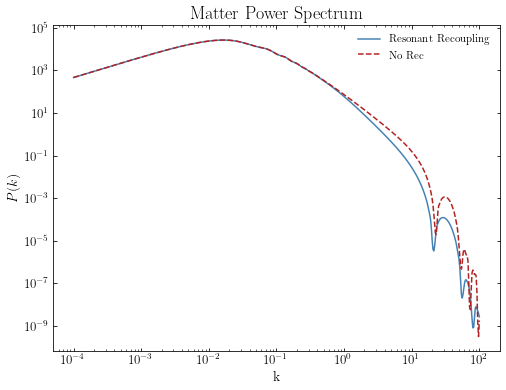

In [20]:
plt.plot(kk, resPk, label='Resonant Recoupling')
plt.plot(kk, noRecPk, '--', label='No Rec')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('$P(k)$')
plt.title('Matter Power Spectrum')
# plt.xlim(1,1e2)
plt.legend()
plt.show()

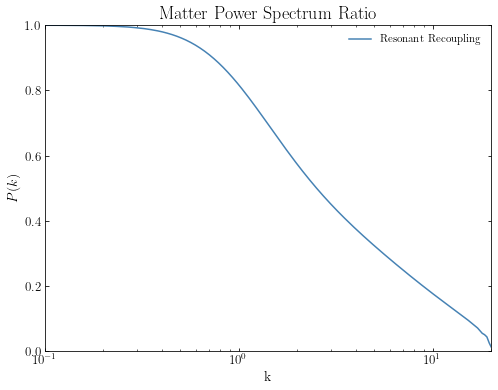

In [30]:
plt.plot(kk, np.array(resPk)/np.array(noRecPk), label='Resonant Recoupling')
plt.yscale('Linear')
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('$P(k)$')
plt.title('Matter Power Spectrum Ratio')
plt.xlim(1e-1,2e1)
plt.ylim(0,1)
plt.legend()
plt.show()

In [31]:
zs_res = cos.get_thermodynamics()['z']
dmus_res = cos.get_thermodynamics()['dmu_idm_dr']

In [32]:
zs_norec = idrNoRec.get_thermodynamics()['z']
dmus_norec = idrNoRec.get_thermodynamics()['dmu_idm_dr']

In [33]:
def conformal_H(z):
    return aprime(thermo_taus(z))/a(thermo_taus(z))

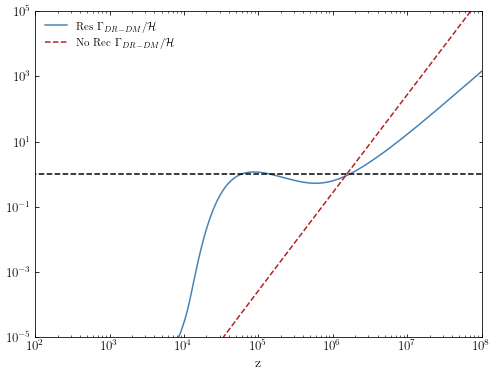

In [34]:
# plt.loglog(zs_res, 1e3*dmus_res/(conformal_H(zs_res)), label='Resonant Recoupling')
# plt.loglog(zs_norec, 5e4*dmus_norec/conformal_H(zs_norec), '--', label='No Rec')
plt.loglog(zs_res, dmus_res/(conformal_H(zs_res)), label='Res $\Gamma_{DR-DM} / \mathcal{H}$')
plt.loglog(zs_norec, dmus_norec/conformal_H(zs_norec), '--', label='No Rec $\Gamma_{DR-DM} / \mathcal{H}$')
plt.loglog([1e-1, 1e9],[1,1], 'k--')
plt.xlabel('z')

plt.xlim(1e2,1e8)
plt.ylim(1e-5, 1e5)

plt.legend()
plt.show()

In [ ]:
LambdaCDM = Class()
LambdaCDM.set(commonset)
LambdaCDM.compute()
LambdaCDMPk = getPk(LambdaCDM);

In [ ]:
model = idrNoRec
with h5py.File(h5pydir+'class_model_data_no_rec.hdf5', 'w') as f:    
    # Scalar group
    data = model.get_perturbations()['scalar']
    sub_group = f.create_group('scalar')
    for i, k in enumerate(BM_KS):
        sub_sub_group = sub_group.create_group(f'k={k}')
        d = data[i]
        for key, val in d.items():
            sub_sub_group.create_dataset(key, data=val)
    
    # Background group
    data = model.get_background()
    sub_group = f.create_group('background')
    for key, val in data.items():
        sub_group.create_dataset(key, data=val)
    
    # Thermo group
    data = model.get_thermodynamics()
    sub_group = f.create_group('thermodynamics')
    for key, val in data.items():
        sub_group.create_dataset(key, data=val)

    # Power Spectrum group
    data = getPk(model)
    sub_group = f.create_group('power_spectrum')
    sub_group.create_dataset('kk', data=kk)
    sub_group.create_dataset('Pk', data=data) 